# DEMO: CLOE

**Description**: this DEMO allows to compute the Galaxy Clustering and Weak Lensing observational probes as defined in the current recipe and computes the likelihood value given some benchmark data. It uses `Cobaya` as the main Bayesian Analysis tool.

It contains three potential different scenarios for the user (called user-cases) corresponding to CASE 1, 2 and 3 in the notebook. A basic description of each of the user-case is the following:

* **CASE 1**: samples the posterior distribution of the parameters of interest (cosmological or nuisance parameters) by running `Cobaya` with the external Euclid Likelihood and the sampler of your choice within the list of samplers available in `Cobaya`. At the moment, this user case executes a single point evaluation of the likelihood using the `Cobaya` sampler `evaluate`.

* **CASE 2**: creates a `model` of `Cobaya` using an internal wrapper of `Cobaya` itself. This wrapper is based on the sampler `evaluate` of `Cobaya`. The `model` allows you to make a single computation of the priors, likelihoods and posterior, measure the time needed by each module or retrieve the information of which theoretical quantities were asked to the Boltzman solvers, for instance. This `model` instance is important, because it is the way the connection between `Cobaya` and the `EuclidLikelihood` code is made internally within `cobaya_interface.py`. In fact, the `model` instance is essential if you want to run CASE 2.1.

* **CASE 2.1**: the final section of the notebook retrieves and plots internal theoretical quantities computed by the CLOE code. Be aware that, to be able to retrieve and plot quantities, you need to run first **CASE 2**, because CASE 2.1 requires the `model` instance to be loaded. You can plot the following quantities:
    * $H(z)$: Hubble factor
    * $r(z)$, $D_A$: comoving and angular diameter distances
    * $\sigma_8$, $f\sigma_8$: amplitude of the (linear) power spectrum on the scale of 8 $h^{-1} Mpc$, and the product of the growth rate, and the amplitude of the (linear) power spectrum on the scale of 8 $h^{-1} Mpc$
    * $D(z)$, $f(z)$: growth factor and growth rate
    * $P_m, P_{gg}, P_{g\delta}, P_{\delta i}, P_{gi}, P_{ii}$: matter power spectrum obtained by the Boltzman solver by `Cobaya` and different power spectra
    * $n(z)$: galaxy density distributions
    * $W_i^{GC}, W_i^{\gamma}, W_i^{IA}$: window functions or kernel for Galaxy Clustering (GC), Shear ($\gamma$) and Intrinsic Alignment.
    * $C_\ell$: angular power spectra
    * $P_\ell$: Legendre multiples


**README**: https://gitlab.euclid-sgs.uk/pf-ist-likelihood/likelihood-implementation/-/blob/master/README.md

**Install**: in order to use this DEMO notebook, you need to clone the repository `https://gitlab.euclid-sgs.uk/pf-ist-likelihood/likelihood-implementation.git`, and install the CLOE as described in the README.
Alternatively you may be ready to run if ```Cobaya``` and ```CAMB/CLASS``` are installed. See details below. 

**Cobaya documentation**: https://cobaya.readthedocs.io/en/latest/

**Python information**: if the user is not confortable with some python vocabulary used in this notebook,
a nice python review can be found here
https://wiki.python.org/moin/BeginnersGuide

In [1]:
# General python imports

import numpy as np
import matplotlib.pyplot as plt
import time 
import os, sys

In [2]:
# If you have clone the repository and open this notebook,
# this notebook should be in likelihood-implementation/notebooks
# Let's set the working directory to be likelihood-implementation

likelihood_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0, likelihood_path)
print('Setting as working directory: ', likelihood_path)

Setting as working directory:  /Users/davide/Documents/Lavoro/Programmi/likelihood-implementation


In [3]:
# Matplotlib params set-up

%matplotlib inline
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=25)
plt.rc('axes', titlesize=26)
plt.rc('axes', labelsize=25)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=6)
plt.rc('legend', fontsize=20)
plt.rc('mathtext', fontset='stix')
plt.rc('font', family='STIXGeneral')

`Cobaya` needs some modules to run: i.e: CAMB, CLASS, Polychord, other likelihood codes, and data (Planck 18, DES...)
If you have installed the CLOE as in the README instructions, you need to activate the conda environment `likelihood` to run. This conda environment has CAMB installed, so you won't need to worry about anything else

Alternatively, if you have already installed Cobaya and other Cosmological codes such as CAMB, CLASS, Polychord, or Planck 18 you have 2 options:

* **(1)**:  point out where each of them is installed with the flag 'path' in the dictionary of cell 5. See the comment in the cell 5 corresponding to the 'theory' key of the 'info' dictionary


* **(2)**: if you installed the Cosmological codes as Cobaya automatic installation suggests  (https://cobaya.readthedocs.io/en/latest/installation_cosmo.html) you need to point out the path to your modules
as in the variable `modules_path` below:

In [4]:
# ATTENTION: write down the path to your COBAYA modules if you want to follow option (2) above.
# Otherwise skip this cell
# modules_path = "/data2/cobaya_modules/"

## CASE 1: 'Run `Cobaya` with Euclid-Likelihood 
**User-case**: *Run and go*. This is the most straightforward case where the user calls `Cobaya` to sample the posterior distribution of the parameters of interest. At the moment, this user-case runs one computation of the likelihood on one point of the parameters space given some theoretical predictions of Euclid observables.

To run, Cobaya needs an 'input file'. Please, read carefully the comments in the cells below to understand 
how this input file looks like and which options are available to be modified by the user.

In [5]:
# Import external loglike from the Likelihood Package within cobaya_interface.py

from cloe.cobaya_interface import EuclidLikelihood

In [6]:
# We are running the Euclid-Likelihood as an external likelihood class for Cobaya
# Cobaya needs a dictionary or yaml file as input to start running
# This dictionary below ('info') can be modified up to some point by the user to
# adapt it to the user's needs.
# The options that can be modified by the user are pointed with the acronym (UC).

info = {
    #'params': Cobaya's protected key of the input dictionary. 
    # Includes the parameters that the user would like to sample over:
'params': {
        # (UC): each parameter below (which is a 'key' of another sub-dictionary) can contain a dictionary
        # with the key 'prior', 'latex'...
        # If the prior dictionary is not passed to a parameter, this parameter is fixed.
        # In this example, we are sampling the parameter ns
        # For more information see: https://cobaya.readthedocs.io/en/latest/example.html
        'ombh2': 0.022445, #Omega density of baryons times the reduced Hubble parameter squared
        'omch2': 0.1205579307, #Omega density of cold dark matter times the reduced Hubble parameter squared
        'H0': 67.0, #Hubble parameter evaluated today (z=0) in km/s/Mpc
        'tau': 0.0925, #optical depth
        'mnu': 0.06, #  sum of the mass of neutrinos in eV
        'nnu': 3.046, #N_eff of relativistic species 
        'As': 2.12605e-9, #Amplitude of the primordial scalar power spectrum
        'ns': 0.96, # primordial power spectrum tilt (sampled with an uniform prior)
        'w': -1.0, #Dark energy fluid model
        'wa': 0.0, #Dark energy fluid model
        'omk': 0.0, #curvature density
        'omegam': None, #DERIVED parameter: Omega matter density
        'omegab': None, #DERIVED parameter: Omega baryon density
        'omeganu': None, #DERIVED parameter: Omega neutrino density
        'omnuh2': None, #DERIVED parameter: Omega neutrino density times de reduced Hubble parameter squared
        'omegac': None, #DERIVED parameter: Omega cold dark matter density
        'N_eff': None,
        # (UC): galaxy bias parameters:
        # The bias parameters below are currently fixed to the
        # values used by the Inter Science Taskforce: Forecast (IST:F)
        # and presented in the corresponding IST:F paper (arXiv: 1910.09273).
        # However, they can be changed by the user and even sample over them by putting a prior
        # Photometric bias parameters
        'b1_photo': 1.0997727037892875,
        'b2_photo': 1.220245876862528,
        'b3_photo': 1.2723993083933989,
        'b4_photo': 1.316624471897739,
        'b5_photo': 1.35812370570578,
        'b6_photo': 1.3998214171814918,
        'b7_photo': 1.4446452851824907,
        'b8_photo': 1.4964959071110084,
        'b9_photo': 1.5652475842498528,
        'b10_photo': 1.7429859437184225,
        # Magnification bias parameters
        'magnification_bias_1': 0.0,
        'magnification_bias_2': 0.0,
        'magnification_bias_3': 0.0,
        'magnification_bias_4': 0.0,
        'magnification_bias_5': 0.0,
        'magnification_bias_6': 0.0,
        'magnification_bias_7': 0.0,
        'magnification_bias_8': 0.0,
        'magnification_bias_9': 0.0,
        'magnification_bias_10': 0.0,
        # Shear calibration multiplicative bias parameters                                                                                                                                                                                                                                                                                                            
        'multiplicative_bias_1': 0.0,
        'multiplicative_bias_2': 0.0,
        'multiplicative_bias_3': 0.0,
        'multiplicative_bias_4': 0.0,
        'multiplicative_bias_5': 0.0,
        'multiplicative_bias_6': 0.0,
        'multiplicative_bias_7': 0.0,
        'multiplicative_bias_8': 0.0,
        'multiplicative_bias_9': 0.0,
        'multiplicative_bias_10': 0.0,
        # Spectroscopic bias parameters
        'b1_spectro': 1.46,
        'b2_spectro': 1.61,
        'b3_spectro': 1.75,
        'b4_spectro': 1.90,
        # Intrinsic alignment parameters
        'aia': 1.72,
        'nia': -0.41,
        'bia': 0.0,
        # Redshift distributions nuisance parameters: shifts
        'dz_1_GCphot': 0.0, 'dz_1_WL': 0.0,
        'dz_2_GCphot': 0.0, 'dz_2_WL': 0.0,
        'dz_3_GCphot': 0.0, 'dz_3_WL': 0.0,
        'dz_4_GCphot': 0.0, 'dz_4_WL': 0.0,
        'dz_5_GCphot': 0.0, 'dz_5_WL': 0.0,
        'dz_6_GCphot': 0.0, 'dz_6_WL': 0.0,
        'dz_7_GCphot': 0.0, 'dz_7_WL': 0.0,
        'dz_8_GCphot': 0.0, 'dz_8_WL': 0.0,
        'dz_9_GCphot': 0.0, 'dz_9_WL': 0.0,
        'dz_10_GCphot': 0.0, 'dz_10_WL': 0.0},
    #'theory': Cobaya's protected key of the input dictionary.
    # Cobaya needs to ask some minimum theoretical requirements to a Boltzman Solver
    # (UC): you can choose between CAMB or CLASS
    # In this DEMO, we use CAMB and specify some CAMB arguments
    # such as the number of massive neutrinos
    # and the dark energy model
    #
    # ATTENTION: If you have CAMB/CLASS already installed and 
    # you are not using the likelihood conda environment 
    # or option (2) in cell (3) (Cobaya modules), you can add an extra key called 'path' within the camb dictionary
    # to point to your already installed CAMB code
    # NOTE: for values of the non-linear flag larger than 0, a new key is added in info['theory']['camb']['extra_args'],
    # i.e. 'halofit_version', which contains the requested version of halofit, as described above
    'theory': {'camb': 
               {'stop_at_error': True, 
                'extra_args':{'num_massive_neutrinos': 1,
                              'dark_energy_model': 'ppf'}}},
    #'sampler': Cobaya's protected key of the input dictionary.
    # (UC): you can choose the sampler you want to use.
    # Check Cobaya's documentation to see the list of available samplers
    # In this DEMO, we use the 'evaluate' sampler to make a single computation of the posterior distributions
    # Note: if you want to run a simple MCMC sampling choose 'mcmc'
    'sampler': {'evaluate': None},  
    # 'packages_path': Cobaya's protected key of the input dictionary.
    # This is the variable you need to update
    # if you are running Cobaya with cobaya_modules (option (2) above).
    # If you are using the conda likelihood environment or option (1),
    # please, keep the line below commented
    #
    #'packages_path': modules_path,
    #
    #'output': Cobaya's protected key of the input dictionary.
    # Where are the results going to be stored, in case that the sampler produce output files? 
    # For example: chains...
    # (UC): modify the path below within 'output' to choose a name and a directory for those files
    'output': 'chains/my_euclid_experiment',
    #'debug': Cobaya's protected key of the input dictionary.
    # (UC): how much information you want Cobaya to print? If debug: True, it prints every single detail
    # that is going on internally in Cobaya
    'debug': False,
    #'timing': Cobaya's protected key of the input dictionary.
    # (UC): if timing: True, Cobaya returns how much time it took it to make a computation of the posterior
    # and how much time take each of the modules to perform their tasks
    'timing': True,
    #'force': Cobaya's protected key of the input dictionary.
    # (UC): if 'force': True, Cobaya forces deleting the previous output files, if found, with the same name
    'force': True,
    }


In [7]:
#'likelihood': Cobaya's protected key of the input dictionary.
# (UC): The user can select which data wants to use for the analysis.
# Check Cobaya's documentation to see the list of the current available data experiments
# In this DEMO, we load the Euclid-Likelihood as an external function, and name it 'Euclid'
info['likelihood'] = {'Euclid': 
                     {'external': EuclidLikelihood, # Likelihood Class to be read as external
                     # Note: everything down below will overwrite the information read
                     # in the config folder
                     #
                     # Select which observables want to use during the analysis
                     # by setting them to True or False
                     'observables_selection': {
                         'WL': {'WL': True, 'GCphot': True, 'GCspectro': False},
                         'GCphot': {'GCphot': True, 'GCspectro': False},
                         'GCspectro': {'GCspectro': False}
                     },
                     # Plot the selected observables matrx
                     'plot_observables_selection': True,
                     'solver': 'camb', 
                      # Non-linear flag
                      # With this, the user can specify which non-linear model they want
                      # For the time-being the available options are: 
                            #0 -> linear-only
                            #1 -> Takahashi
                            #2 -> Mead2020 (w/o baryon corrections)
                     'NL_flag': 0,
                     # k values for extrapolation of the matter power spectrum and size k-array
                     'k_max_extrap': 500.0,
                     'k_min_extrap': 1E-5,   
                     'k_samp': 1000,
                     # z limit values and size z-array
                     'z_min': 0.0,
                     'z_max': 4.0,
                     'z_samp': 100,
                     # Add RSD to photometric probes
                     'add_phot_RSD': False,
                     #'data': This give specifications for the paths of the input data files
                     'data': { 
                        #'sample' specifies the first folder below the main data folder
                        'sample': 'ExternalBenchmark',
                        #'spectro' and 'photo' specify paths to data files.
                        'spectro': {
                            # GC Spectro root name should contain z{:s} string
                            # to enable iteration over bins
                            'root': 'cov_power_galaxies_dk0p004_z{:s}.fits',
                            'redshifts': ["1.", "1.2", "1.4", "1.65"],
                            'edges': [0.9, 1.1, 1.3, 1.5, 1.8]},
                        'photo': {
                            'ndens_GC': 'niTab-EP10-RB00.dat',
                            'ndens_WL': 'niTab-EP10-RB00.dat',
                            'luminosity_ratio': 'luminosity_ratio.dat',
                            # Photometric root names should contain z{:s} string
                            # to specify IA model
                            'root_GC': 'Cls_{:s}_PosPos.dat',
                            'root_WL': 'Cls_{:s}_ShearShear.dat',
                            'root_XC': 'Cls_{:s}_PosShear.dat',
                            'IA_model': 'zNLA',
                            # Photometric covariances root names should contain z{:s} string
                            # to specify how the covariance was calculated
                            'cov_GC': 'CovMat-PosPos-{:s}-20Bins.npy',
                            'cov_WL': 'CovMat-ShearShear-{:s}-20Bins.npy',
                            # 'cov_3x2pt': 'CovMat-3x2pt-{:s}-20Bins.npy',  # old ordering (i.e., 3x2ptell_probe_zpair), needs _unpack_3x2pt_cov to be reshaped to the correct form
                            # 'cov_3x2pt': 'CovMat-3x2pt-{:s}-20Bins-probe_zpair_ell.npy',  # shape used before Santiago's modification (the old correct shape)
                            'cov_3x2pt': 'CovMat-3x2pt-{:s}-20Bins-probe_ell_zpair.npy',  # shape used after Santiago's modification (aka the new correct shape)
                            
                            'cov_model': 'Gauss'}}, 
                   
                    }}

### Create the yaml file corresponding to the Likelihood Parameters
Cobaya needs to know which parameters the likelihood `EuclidLikelihood` expects (for example, nuisance parameters), apart from the cosmological parameters (i.e: $\Omega_b$, $H_0$, $n_s$...) which are already known by the theory code (CAMB/CLASS). 

For that, a `yaml` file is generated instead of having those likelihood parameters hard-coded within `cobaya_interface.py`. To generate this `yaml` file, execute either the next cell or the next-to-next.

Please, be aware that this function will only make Cobaya expect those likelihood parameters. To set some fixed values or put a prior on them, the user needs to do so within the `info` python dictionary above. 

In [8]:
from cloe.auxiliary.likelihood_yaml_handler import set_halofit_version
# Set the correct halofit version under the 'extra_args' field in ['theory']['camb']
set_halofit_version(info, info['likelihood']['Euclid']['NL_flag'])
# Now we are ready to run Cobaya

In [9]:
# An alternative way from using an hardcoded Cobaya info dictionary is loading the Cobaya configuration from a yaml file.
# Run this cell only if you want to load the info dictionary from file.
run_this_cell = False
# WARNING: running this cell will overload the info dictionary defined in the previous cells

from cloe.auxiliary.likelihood_yaml_handler import get_default_configs_path
from cloe.auxiliary.likelihood_yaml_handler import update_cobaya_params_from_model_yaml
from cloe.auxiliary.likelihood_yaml_handler import update_cobaya_dict_with_halofit_version
from cloe.auxiliary.yaml_handler import yaml_read

if run_this_cell:
    # A test configuration yaml file is in 'configs/config_test.yaml'
    # We can play with this file, or use another config file ...
    config_test_path = get_default_configs_path() / 'config_test.yaml'
    # Loading the dictionary from the file
    config_test_dict = yaml_read(config_test_path)
    info = config_test_dict['Cobaya']
    # And read the model file name (only for this case, 'params' value is a file name where the model is specified)
    # We can play with this model file, or use another model file ...
    model_file = info['params']
    # Joining the complete path for the model file
    model_path = config_test_path.parent.joinpath(model_file)
    # Updating the Cobaya info dictionary from the model
    # i.e. writing the whole 'params' dict instead of the model file name
    update_cobaya_params_from_model_yaml(info, model_path)
    # Updating the Cobaya dictionary to add the halofit version corresponding to the selected NL flag
    update_cobaya_dict_with_halofit_version(info)
    set_halofit_version(info, info['likelihood']['Euclid']['NL_flag'])


# Now we are ready to run cobaya

[output] Output to be read-from/written-into folder 'chains', with prefix 'my_euclid_experiment'
[output] Found existing info files with the requested output prefix: 'chains/my_euclid_experiment'
[output] Will delete previous products ('force' was requested).
[camb] `camb` module loaded successfully from /opt/anaconda3/envs/cloe/lib/python3.9/site-packages/camb


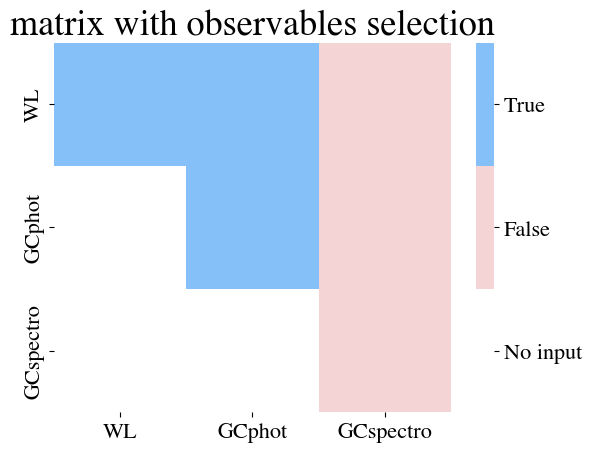

[camb] `camb` module loaded successfully from /opt/anaconda3/envs/cloe/lib/python3.9/site-packages/camb
[model] *WARNING* Theories {camb, camb.transfers} do not appear to be actually used for anything


/Users/davide/Documents/Lavoro/Programmi/likelihood-implementation/cloe/photometric_survey/photo.py:193: UserWarning: Bessel tables have been set with the specified angular separations. Computing 3x2pt correlation functions at different angles will lead to unexpected outputs.
  warnings.warn('Bessel tables have been set with the specified angular '


[evaluate] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[evaluate] Initialized!
[evaluate] Looking for a reference point with non-zero prior.
[evaluate] Reference point:
   
[evaluate] Evaluating prior and likelihoods...
not doing any matrix transform
not doing any matrix transform
not doing any matrix transform
not doing any matrix transform
not doing any matrix transform
not doing any matrix transform
[evaluate] log-posterior  = -0.0373388
[evaluate] log-prior      = 0
[evaluate]    logprior_0 = 0
[evaluate] log-likelihood = -0.0373388
[evaluate]    chi2_Euclid = 0.0746776
[evaluate] Derived params:
[evaluate]    omegam = 0.32
[evaluate]    omegab = 0.05
[evaluate]    omeganu = 0.00143715
[evaluate]    omnuh2 = 0.000645138
[evaluate]    omegac = 0.268563
[evaluate]    N_eff = 3.046
[euclid] Average evaluation time for Euclid: 6.24398 s  (1 evaluations)
[camb.transfers] Average evaluation time for camb.transfers: 1.06424 s  (1 evaluations)
[camb] Av

In [10]:
# Import Cobaya run function
from cobaya.run import run
import matplotlib
matplotlib.rcParams['text.usetex'] = False

# Let's run Cobaya
# the function run returns
# info_updated: an information dictionary updated with the defaults, 
# equivalent to the updated yaml file produced by the shell invocation
# samples: a sampler object, with a sampler.products() 
# being a dictionary of results. 
# For the mcmc sampler, the dictionary contains only one chain under the key sample.

info_updated, samples = run(info)

**Explanation of the printed output by Cobaya**: 
- output: it tells details about the output
- Prior: it shows the values sampled by the prior. In this case, our parameters of interest are all fixed so Cobaya reminds that.
- CAMB: it calls the theory code you wanted to use (CAMB/CLASS, in this case, CAMB, and where it is installed).

You see these outputs repeated twice because the CLOE calls `Cobaya` internally twice, within the EuclidLikelihood, to calculate the fiducial cosmology.
- evaluate: the 'evaluate' sampler gets initialized, looks for a point and evaluates the posterior.

Note that since the option timing is True in the info dictionary, Cobaya tells you how much time it took to compute the likelihood (euclid) and CAMB

# Case 2: Run `Cobaya model` with Euclid-Likelihood as external likelihood 

**User-case**: the analysis tool `Cobaya` has a wrapper of its `evaluate` sampler (the one executed in CASE 1), called `model`, that allows to:

* make an evaluation in a single point of prior, likelihood and posterior distributions
* retrieve derived parameters and other quantities

The `model` wrapper is useful for debugging as well (i.e: imagine you are running a MCMC sampling to find the best-fit values of a given model, and the MCMC chains get stuck for unknown reasons). With the `model`, you can investigate what is going on internally in `Cobaya` at each step of the sampling algorithm.

Moreover, our EuclidLikelihood code, which is designed to work as an external likelihood code for `Cobaya` relies on this `model` wrapper to make the connection between `Cobaya`, the likelihood calculation and the computation of the theoretical predictions (see **CASE 2.1** for further information).

In this **CASE 2**, we will see how to activate the `model` wrapper, how to use it and how to understand the output it provides.

[model] *WARNING* Ignored blocks/options: ['sampler', 'output', 'force']
[camb] `camb` module loaded successfully from /opt/anaconda3/envs/cloe/lib/python3.9/site-packages/camb


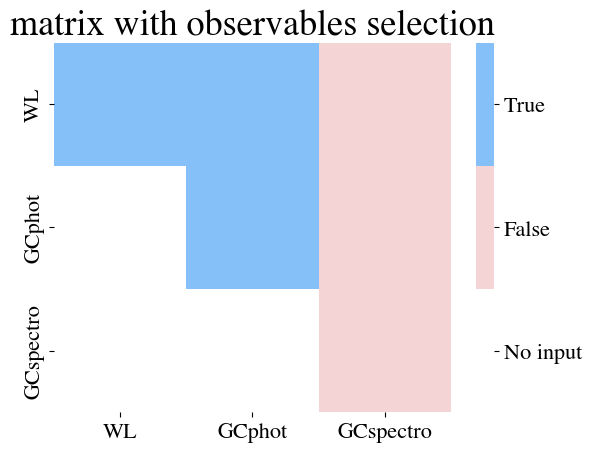

[camb] `camb` module loaded successfully from /opt/anaconda3/envs/cloe/lib/python3.9/site-packages/camb
[model] *WARNING* Theories {camb.transfers, camb} do not appear to be actually used for anything


/Users/davide/Documents/Lavoro/Programmi/likelihood-implementation/cloe/photometric_survey/photo.py:193: UserWarning: Bessel tables have been set with the specified angular separations. Computing 3x2pt correlation functions at different angles will lead to unexpected outputs.
  warnings.warn('Bessel tables have been set with the specified angular '


Time for initialization of the likelihood:  5.765074968338013


In [11]:
# First: import model wrapper of Cobaya 
from cobaya.model import get_model

# The `get_model` function of Cobaya imported in the line above needs a yaml or dictionary as an argument
# exactly the same as the function `run` in cell 9 also needs.
#
# We measure the time to give us an estimation of how much time it takes to make the initialization of the
# likelihood

t1 = time.time()

# Second: create an instance of the `model` wrapper called model
model = get_model(info)
print('Time for initialization of the likelihood: ', time.time()-t1)

**Explanation of the printed output by Cobaya**: 

- Model: it tells you Cobaya is using the `model` wrapper, and it's reading the info dictionary.
- Prior: it shows the values sampled by the prior. In this case, our parameters of interest are all fixed so Cobaya reminds that.
- CAMB: it calls the theory code you wanted to use (CAMB/CLASS, in this case, CAMB, and where it is installed).

You see these outputs repeated twice because the CLOE calls Cobaya internally twice, within the EuclidLikelihood, to calculate the fiducial cosmology.

It takes around 10 seconds to initialize the likelihood (reading OU-LE3 data and computing fiducial cosmology) 

### Functionalities of the `model` wrapper:
As mentioned above, we can get an insight of what `Cobaya` is doing using the `model` object. We can ask, for instance:
 * (1) which quantities were **required** by the likelihood code and asked to the Boltzman solver through `Cobaya`
 * (2) at which values (i.e: redshift, scales...) those requirements were **requested**.
 
To see how to ask for these quantities, execute the cell below:

In [12]:
# (1) Requirements needed by the likelihood code.
# That means, which quantities are we asking to the Boltzman (CAMB/CLASS) through Cobaya?
print('\n Requirements \n')
print(model.provider.requirement_providers)
# (2) At which values have the requirements been requested (redshift, scales...)?
print('\n Requested \n')
print(model.requested())


 Requirements 

{'omegam': camb, 'Pk_interpolator': camb, 'comoving_radial_distance': camb, 'angular_diameter_distance': camb, 'Hubble': camb, 'sigma8_z': camb, 'fsigma8': camb, 'omegab': camb, 'omegac': camb, 'omnuh2': camb, 'omeganu': camb, 'CAMB_transfers': camb.transfers}

 Requested 

{'camb.transfers': [{'CAMB_transfers':{'non_linear': False, 'needs_perts': False}}, {'CAMB_transfers':{'non_linear': False, 'needs_perts': True}}], 'camb': [{'omegam':None}, {'omegab':None}, {'omeganu':None}, {'omnuh2':None}, {'omegac':None}, {'N_eff':None}, {'Pk_interpolator':{}}, {'comoving_radial_distance':{'z': array([0.        , 0.04040404, 0.08080808, 0.12121212, 0.16161616,
       0.2020202 , 0.24242424, 0.28282828, 0.32323232, 0.36363636,
       0.4040404 , 0.44444444, 0.48484848, 0.52525253, 0.56565657,
       0.60606061, 0.64646465, 0.68686869, 0.72727273, 0.76767677,
       0.80808081, 0.84848485, 0.88888889, 0.92929293, 0.96969697,
       1.01010101, 1.05050505, 1.09090909, 1.13131313, 1

In [13]:
#print(model.provider.requirement_providers)

* (3) With the `model` wrapper you can also make an evaluation of the prior, likelihood and posterior distributions

ATTENTION: we initialized the `model` wrapper by reading the `info` dictionary above. This `info` dictionary has almost all the parameters of interest fixed (the only sampled parameters is $n_s$). Therefore, to make an evaluation of the probability distributions (priors, likelihoods and posterior), you need:

* First: get a point of the sampled parameters from the prior distribution 
* Second: pass this point to the logposterior method

See comments in the cell below to understand how to retrieve the values of these distributions.

In [14]:
# At the moment, we are sampling only ns
# if there are sampled parameters, we need first to obtain a value from the prior
# i.e: (FIRST)
point = dict(zip(model.parameterization.sampled_params(),
                 model.prior.sample(ignore_external=True)[0]))
t1 = time.time()
# (3) Make a computation of the logposterior on that point
logposterior = model.logposterior(point)
# If there were no sampled parameters, you can simply do
#logposterior = model.logposterior({})
t2 = time.time()

# Note that we are measuring the time for illustration purposes only.

print('Time to compute the logposterior: ', t2-t1)
print('Full log-posterior:')
print('   logposterior: %g' % logposterior.logpost)
print('   logpriors: %r' % dict(zip(list(model.prior), logposterior.logpriors)))
print('   loglikelihoods: %r' % dict(zip(list(model.likelihood), logposterior.loglikes)))
print('   derived params: %r' % dict(zip(list(model.parameterization.derived_params()), logposterior.derived)))

IndexError: index 0 is out of bounds for axis 0 with size 0

# Case 2.1: EuclidLikelihood package

**User-case**: this case allows the user to go one level deeper down into the CLOE code, so that the user can retrieve and plot:

* Benchmark data used as mock data during the calculation of the likelihood. For instance:
    * $n(z)$: galaxy density distributions
* Cosmological quantities provided by the Boltzman solver through `Cobaya`. For example:
    * $H(z)$: Hubble factor
    * $r(z)$, $D_A$: comoving and angular diameter distances
    * $\sigma_8$, $f\sigma_8$: amplitude of the (linear) power spectrum on the scale of 8 $h^{-1} Mpc$, and the product of the growth rate times the amplitude of the power spectrum at that same scale.
* Internal cosmological quantities computed by the EuclidLikelihood package itself:
    * $D(z)$, $f(z)$: growth factor and growth rate
    * $P_m, P_{gg}, P_{g\delta}, P_{\delta i}, P_{gi}, P_{ii}$: matter power spectrum obtained by the Boltzman solver by `Cobaya` and different power spectra
* Theoretical predictions of the photometric and spectroscopic observables
    * $W_i^{GC}, W_i^{\gamma}, W_i^{IA}$: window functions or kernel for Galaxy Clustering (GC), Shear ($\gamma$) and Intrinsic Alignment.
    * $C_\ell$: angular power spectra
    * $P_\ell$: Legendre multiples
* computation of the $\chi^2$

To be able to access all these quantities and get a grasp of what EuclidLikelihood actually does, **you need to have loaded an instance of the `model` wrapper of Cobaya (explained in CASE 2)**. In reality, what we are doing in this **CASE 2.1** is to reproduce the steps that are done internally by `Cobaya` at each step of the sampling procedure within the file `cobaya_interface.py` of the likelihood package. Therefore, understanding **CASE 2.1** will also help the user to understand the details of the EuclidLikelihood source code and structure.



In [ ]:
# Create an instance of the class EuclidLikelihood
like = EuclidLikelihood()

# Initialize default parameters for redshift, k-array, fiducial cosmology...
like.initialize()

# Get the cosmo_dictionary where all the cosmology + theory parameters are saved
# ATTENTION: as explained above, you need to pass the `cobaya wrapper model` initialized 
# in CASE 2 as an argument of the function, as well as the parameters of your theory.
# In CASE 1, when only Cobaya run is used, it creates internally this `model` instance itself
like.passing_requirements(model, info, **model.provider.params)

# Update the cosmology dictionary with interpolators + basic quantities such as
# P_gg, P_delta...
like.cosmo.update_cosmo_dic(like.cosmo.cosmo_dic['z_win'], 0.05)

# Show what the cosmo_dic actually contains
print('\nKeys of the cosmo_dic: \n', list(like.cosmo.cosmo_dic.keys()))
print('\nKeys of the nuisance params within cosmo_dic: \n', list(like.cosmo.cosmo_dic['nuisance_parameters'].keys()))

In [ ]:
# You can also access the quantities of the euclike module as follows:
# This function will return the loglike
loglike = like.likefinal.loglike(like.cosmo.cosmo_dic)
# This loglike agrees with the one read by Cobaya if the Likelihood external code works fine
print('loglike: ', loglike)

In [ ]:
# After the computation of the chi2, you can access the following quantities of the euclike module
print('\nList of attributes of the euclike object: \n', list(vars(like.likefinal)))

In [ ]:
# To print, for instance, the mean of the redshift bins used in the computation
print(like.likefinal.zkeys)

### Plot internal quantities and cosmological observables

In [ ]:
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rc('font',size=20)
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=20)
plt.rc('lines', linewidth=3)
plt.rc('lines', markersize=6)
plt.rc('legend', fontsize=20)

In [ ]:
# Let's plot the background quantities of cosmo_dic
# See http://pf-ist-likelihood.pages.euclid-sgs.uk/likelihood-implementation/likelihood.cosmo.cosmology.html
# for extra information

fig, axs = plt.subplots(2, 2, figsize=(13,10))
for ax in axs.flatten():
    ax.tick_params(axis='both',which='both',direction='in')
fig.suptitle('Background quantities')
axs[0, 0].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['H_z_func'](like.cosmo.cosmo_dic['z_win']))
axs[0, 0].set_xlabel(r'$z$')
axs[0, 0].set_ylabel(r'$H(z)$ $\left[ \frac{\rm{km}}{\rm{s}\cdot \rm{Mpc}}\right]$')
axs[0, 1].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['d_z_func'](like.cosmo.cosmo_dic['z_win']),
              label = r'$D_{\rm{A}}(z)$ $[\rm{Mpc}]$')
axs[0, 1].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['r_z_func'](like.cosmo.cosmo_dic['z_win']), '--',
              label = r'$r(z)$')
axs[0, 1].set_xlabel(r'$z$')
axs[0, 1].legend(frameon=False)
axs[1, 0].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['sigma8_z_func'](like.cosmo.cosmo_dic['z_win']),
              label = r'$\sigma_8(z)$')
axs[1, 0].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['fsigma8_z_func'](like.cosmo.cosmo_dic['z_win']),
              '--', label = r'$f\sigma_8(z)$')
axs[1, 0].set_xlabel(r'$z$')
axs[1, 0].legend(frameon=False)
axs[1, 1].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['D_z_k'],
              label = r'$D(z)$')
axs[1, 1].plot(like.cosmo.cosmo_dic['z_win'], 
               like.cosmo.cosmo_dic['f_z'](like.cosmo.cosmo_dic['z_win']),
              '--', label = r'$f = f\sigma_8/\sigma_8$')
axs[1, 1].set_xlabel(r'$z$')
axs[1, 1].legend(frameon=False)

plt.tight_layout()
plt.subplots_adjust(top=0.90)

In [ ]:
# Let's plot the matter power spectrum and other spectra quantities
# 'Pgg_spectro', 'Pgg_phot', 'Pgdelta_phot', 'Pgdelta_spectro', 'Pii', 'Pdeltai', 'Pgi_phot', 'Pgi_spectro'
# See http://pf-ist-likelihood.pages.euclid-sgs.uk/likelihood-implementation/likelihood.cosmo.cosmology.html
# for extra information

k_label           = r'$k$ $[\rm{Mpc}^{-1}]$'
pm_label          = r'$P_{\rm{m}} \left[\rm{Mpc}^3\right]$'
pgg_spectro_label = r'$P_{\rm{gg}}^{\,\rm{spectro}} \left[\rm{Mpc}^3\right]$'
pgg_phot_label    = r'$P_{\rm{gg}}^{\,\rm{phot}} \left[\rm{Mpc}^3\right]$'
pgd_spectro_label = r'$P_{\rm{g}\delta}^{\,\rm{spectro}} \left[\rm{Mpc}^3\right]$'
pgd_phot_label    = r'$P_{\rm{g}\delta}^{\,\rm{phot}} \left[\rm{Mpc}^3\right]$'
pII_label         = r'$P_{\,\rm{II}} \left[\rm{Mpc}^3\right]$'
pdI_label         = r'$P_{\delta\rm{I}} \left[\rm{Mpc}^3\right]$'
pgI_phot_label    = r'$P_{\rm{gI}}^{\,\rm{phot}} \left[\rm{Mpc}^3\right]$'
pgI_spectro_label = r'$P_{\rm{gI}}^{\,\rm{spectro}} \left[\rm{Mpc}^3\right]$'


# WARNING: AT THE MOMENT, THE LARGE SCALES (small k values) in the power spectra are not physical
import warnings
warnings.filterwarnings('ignore')
fig, axs = plt.subplots(9, 2, figsize=(13,47))
for ax in axs.flatten():
    ax.tick_params(axis='both',which='both',direction='in')
fig.suptitle('Spectra')
ks=np.logspace(-5, 0, 100)
axs[0, 0].loglog(ks, like.cosmo.cosmo_dic['Pk_delta'].P(like.cosmo.cosmo_dic['z_win'][0], ks), 'o', 
           label=r"z = {:.2f}".format(like.cosmo.cosmo_dic['z_win'][0]))
axs[0, 0].set_xlabel(k_label)
axs[0, 0].set_ylabel(pm_label)
axs[0, 0].legend(frameon=False)
#------
axs[0, 1].loglog(ks, like.cosmo.cosmo_dic['Pk_delta'].P(like.cosmo.cosmo_dic['z_win'][-1], ks), 'o', 
           label=r"z = {:.2f}".format(like.cosmo.cosmo_dic['z_win'][-1]))
axs[0, 1].set_xlabel(k_label)
axs[0, 1].set_ylabel(pm_label)
axs[0, 1].legend(frameon=False)
#------
for i, k in enumerate(ks):
    axs[1, 0].loglog(k, like.cosmo.cosmo_dic['Pgg_spectro'](
    like.cosmo.cosmo_dic['z_win'][25], k, 1), 'ko', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][25]) if i == 0 else "")
    axs[1, 1].loglog(k, like.cosmo.cosmo_dic['Pgg_spectro'](
    like.cosmo.cosmo_dic['z_win'][35], k, 1), 'ko', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][35]) if i == 0 else "")
axs[1, 0].set_xlabel(k_label)
axs[1, 0].set_ylabel(pgg_spectro_label)
axs[1, 1].set_xlabel(k_label)
axs[1, 1].set_ylabel(pgg_spectro_label)
axs[1, 0].legend(frameon=False)
axs[1, 1].legend(frameon=False)

#------
for i, k in enumerate(ks):
    axs[2, 0].loglog(k, like.cosmo.cosmo_dic['Pgg_phot'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'go', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[2, 1].loglog(k, like.cosmo.cosmo_dic['Pgg_phot'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'go', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[2, 0].set_xlabel(k_label)
axs[2, 0].set_ylabel(pgg_phot_label)
axs[2, 1].set_xlabel(k_label)
axs[2, 1].set_ylabel(pgg_phot_label)
axs[2, 0].legend(frameon=False)
axs[2, 1].legend(frameon=False)

#------
for i, k in enumerate(ks):
    axs[3, 0].loglog(k, like.cosmo.cosmo_dic['Pgdelta_spectro'](
    like.cosmo.cosmo_dic['z_win'][25], k, 1), 'ko', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][25]) if i == 0 else "")
    axs[3, 1].loglog(k, like.cosmo.cosmo_dic['Pgdelta_spectro'](
    like.cosmo.cosmo_dic['z_win'][35], k, 1), 'ko', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][35]) if i == 0 else "")
axs[3, 0].set_xlabel(k_label)
axs[3, 0].set_ylabel(pgd_spectro_label)
axs[3, 1].set_xlabel(k_label)
axs[3, 1].set_ylabel(pgd_spectro_label)
axs[3, 0].legend(frameon=False)
axs[3, 1].legend(frameon=False)


#------
for i, k in enumerate(ks):
    axs[4, 0].loglog(k, like.cosmo.cosmo_dic['Pgdelta_phot'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'go', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[4, 1].loglog(k, like.cosmo.cosmo_dic['Pgdelta_phot'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'go', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[4, 0].set_xlabel(k_label)
axs[4, 0].set_ylabel(pgd_phot_label)
axs[4, 1].set_xlabel(k_label)
axs[4, 1].set_ylabel(pgd_phot_label)
axs[4, 0].legend(frameon=False)
axs[4, 1].legend(frameon=False)

#------
for i, k in enumerate(ks):
    axs[5, 0].loglog(k, like.cosmo.cosmo_dic['Pii'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'ro', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[5, 1].loglog(k, like.cosmo.cosmo_dic['Pii'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'ro', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[5, 0].set_xlabel(k_label)
axs[5, 0].set_ylabel(pII_label)
axs[5, 1].set_xlabel(k_label)
axs[5, 1].set_ylabel(pII_label)
axs[5, 0].legend(frameon=False)
axs[5, 1].legend(frameon=False)

#------
for i, k in enumerate(ks):
    axs[6, 0].semilogx(k, like.cosmo.cosmo_dic['Pdeltai'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'bo', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[6, 1].semilogx(k, like.cosmo.cosmo_dic['Pdeltai'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'bo', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[6, 0].set_xlabel(k_label)
axs[6, 0].set_ylabel(pdI_label)
axs[6, 1].set_xlabel(k_label)
axs[6, 1].set_ylabel(pdI_label)
axs[6, 0].legend(frameon=False, loc=4)
axs[6, 1].legend(frameon=False, loc=4)

#------
for i, k in enumerate(ks):
    axs[7, 0].semilogx(k, like.cosmo.cosmo_dic['Pgi_phot'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'go', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[7, 1].semilogx(k, like.cosmo.cosmo_dic['Pgi_phot'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'go', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[7, 0].set_xlabel(k_label)
axs[7, 0].set_ylabel(pgI_phot_label)
axs[7, 1].set_xlabel(k_label)
axs[7, 1].set_ylabel(pgI_phot_label)
axs[7, 0].legend(frameon=False, loc=4)
axs[7, 1].legend(frameon=False, loc=4)

#------
for i, k in enumerate(ks):
    axs[8, 0].semilogx(k, like.cosmo.cosmo_dic['Pgi_spectro'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'ko', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[8, 1].semilogx(k, like.cosmo.cosmo_dic['Pgi_spectro'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'ko', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[8, 0].set_xlabel(k_label)
axs[8, 0].set_ylabel(pgI_spectro_label)
axs[8, 1].set_xlabel(k_label)
axs[8, 1].set_ylabel(pgI_spectro_label)
axs[8, 0].legend(frameon=False, loc=4)
axs[8, 1].legend(frameon=False, loc=4)

plt.tight_layout()
plt.subplots_adjust(top=0.97)


In [ ]:
# We can also plot the initial data read by the like_calc module (class Euclike). 
# This data is at the moment the fiducial data store within the data folder of the repository

# i.e: let's plot the galaxy distributions for GC-photo(z) and WL (AT THE MOMENT, THEY ARE THE SAME)
zs = np.linspace(0, 4, 1000)
fig, axs = plt.subplots(2, 1, figsize=(10,10))
for ax in axs.flatten():
    ax.tick_params(axis='both',which='both',direction='in')
for key, value in like.likefinal.data_ins.nz_dict_GC_Phot.items():
    axs[0].plot(zs, value(zs), label = key)
for key, value in like.likefinal.data_ins.nz_dict_WL.items():
    axs[1].plot(zs, value(zs), label = key)
axs[0].set_xlabel(r'$z$')
axs[0].set_ylabel(r'$n(z)$ $\left[\rm{sr}^{-1}\right]$')
axs[0].set_title(r'${\rm{GC-photo}}(z)$')
axs[0].legend(frameon=False, ncol=2)
axs[1].set_xlabel(r'$z$')
axs[1].set_ylabel(r'$n(z)$ $\left[\rm{sr}^{-1}\right]$')
axs[1].set_title(r'$\rm{WL}$')
axs[1].legend(frameon=False, ncol=2);
#plt.subplots_adjust(top=0.90)
plt.tight_layout()

In [ ]:
# We can also plot the window functions for the photometric observables
# For that, you need to import the photo class and read the cosmology dictionary and the n(z) distributions above
from cloe.photometric_survey.photo import Photo
photo = Photo(like.cosmo.cosmo_dic, like.likefinal.data_ins.nz_dict_WL, like.likefinal.data_ins.nz_dict_GC_Phot)

In [ ]:
import matplotlib.colors as mcolors
color = list(mcolors.TABLEAU_COLORS.values())
fig, axs = plt.subplots(3, 1, figsize=(13,12))
for ax in axs.flatten():
    ax.tick_params(axis='both',which='both',direction='in')
for i in range(0, 10):
    print('bin: {}'.format(i+1))
    axs[0].plot(zs, photo.GC_window(zs, i+1), '-', color = color[i], label='n{}'.format(i+1))
    axs[1].plot(zs, photo.WL_window(zs, i+1), '-', color = color[i], label='n{}'.format(i+1))
    axs[2].plot(zs, photo.IA_window(zs, i+1), '-', color = color[i], label='n{}'.format(i+1))
axs[0].set_xlabel(r'$z$')
axs[0].set_ylabel(r'$W_i^{\rm{GC-photo}}$ $\left[\rm{Mpc}^{-1}\right]$')
axs[0].legend(frameon=False, ncol=2)
axs[1].set_xlabel(r'$z$')
axs[1].set_ylabel(r'$W_i^{\gamma}$ $\left[\rm{Mpc}^{-1}\right]$')
axs[1].legend(frameon=False, ncol=2)
axs[2].set_xlabel(r'$z$')
axs[2].set_ylabel(r'$W_i^{\rm{IA}}$ $\left[\rm{Mpc}^{-1}\right]$')
axs[2].legend(frameon=False, ncol=2)

plt.tight_layout()

### Plot Euclid final observables

We can use the auxiliary module of the CLOE to plot the final observables. **Have in mind that the predicted values for the angular power spectra will probably not agree with the fiducial plotted values from the Benchmark data as we are currently sampling $n_s$.**

In [ ]:
# We import the Plotter Class
from cloe.auxiliary.plotter import Plotter

In [ ]:
for k in model.parameterization.sampled_params():
    print(k)

In [ ]:
# Weak-Lensing angular power spectrum according to the IST:L recipe 
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
ax1.tick_params(axis='both',which='both',direction='in')
for param in model.parameterization.sampled_params().keys():
        pl_label = 'ns'#'{}={:.4f}'.format(param, model.parameterization.sampled_params()[param])
        print('WARNING: param {} is being sampled! Possible mismatch between benchmark and theoretical prediction'.format(param))
pl_label = 'ns'
pl_inst = Plotter(cosmo_dic=like.cosmo.cosmo_dic, data=like.likefinal.data)
ax1 = pl_inst.plot_external_Cl_phot(1, 1, ax1, probe='WL', pl_label='Benchmark')
ax1 = pl_inst.plot_Cl_phot(np.logspace(1, 3.6, 10), 1, 1, ax1, probe='WL', pl_colour='r', pl_linestyle='--', pl_label=pl_label)
ax1.set_xlabel(r'$\ell$', fontsize=20)
ax1.set_ylabel(r'$C_\ell$ $\left[\rm{sr}\right]$', fontsize=20)
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_title('Weak-Lensing bin1')
ax1.legend();

In [ ]:
# GC-photo(z) angular power spectrum

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
ax1.tick_params(axis='both',which='both',direction='in')
for param in model.parameterization.sampled_params().keys():
        pl_label = '{}={:.4f}'.format(param, model.parameterization.sampled_params()[param])
        print('WARNING: param {} is being sampled! Possible mismatch between benchmark and theoretical prediction'.format(param))
ax1 = pl_inst.plot_external_Cl_phot(1, 1, ax1, probe='GC-Phot', pl_label='Benchmark')
ax1 = pl_inst.plot_Cl_phot(np.logspace(1, 3.6, 10), 1, 1, ax1, probe='GC-Phot', pl_colour='r', pl_linestyle='--', pl_label=pl_label)
ax1.set_xlabel(r'$\ell$', fontsize=20)
ax1.set_ylabel(r'$C_\ell$ $\left[\rm{sr}\right]$', fontsize=20)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('GC-photo(z) bin1')
ax1.legend();

In [ ]:
# Cross-correlation WL x GC-photo(z) angular power spectrum

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
ax1.tick_params(axis='both',which='both',direction='in')
for param in model.parameterization.sampled_params().keys():
        pl_label = '{}={:.4f}'.format(param, model.parameterization.sampled_params()[param])
        print('WARNING: param {} is being sampled! Possible mismatch between benchmark and theoretical prediction'.format(param))
ax1 = pl_inst.plot_external_Cl_XC(1, 1, ax1, pl_label='Benchmark')
ax1 = pl_inst.plot_Cl_XC(np.logspace(1, 3.6, 10), 1, 1, ax1, pl_colour='r', pl_linestyle='--', pl_label=pl_label)
ax1.set_xlabel(r'$\ell$', fontsize=20)
ax1.set_ylabel(r'$C_\ell$ $\left[\rm{sr}\right]$', fontsize=20)
ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_title('WL x GC-photo(z) bin1')
ax1.legend();

In [ ]:
# GC-spectro observable

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
ax1.tick_params(axis='both',which='both',direction='in')
for param in model.parameterization.sampled_params().keys():
        pl_label = '{}={:.4f}'.format(param, model.parameterization.sampled_params()[param])
        print('WARNING: param {} is being sampled! Possible mismatch between benchmark and theoretical prediction'.format(param))
ax1 = pl_inst.plot_external_GC_spectro("1.2", 2, ax1, pl_label='Benchmark')
ax1 = pl_inst.plot_GC_spectro_multipole(1.2, np.linspace(0.01, 0.5), 2, ax1, pl_colour='r', pl_linestyle='--', pl_label=pl_label)
ax1.set_xlabel(r'$k$ $\left[\rm{Mpc}^{-1}\right]$', fontsize=20)
ax1.set_ylabel(r'$P_\ell$ $\left[\rm{Mpc}^3\right]$', fontsize=20)
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_title('GC-spectro bin1')
ax1.legend();